# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         print(tip)

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1051 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
#another batch from the iterator
batch = data_iterator.next()

In [15]:
#Class 1 = ATTRACTIVE
#Class 0 = UNATTRACTIVE
batch[1]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1])

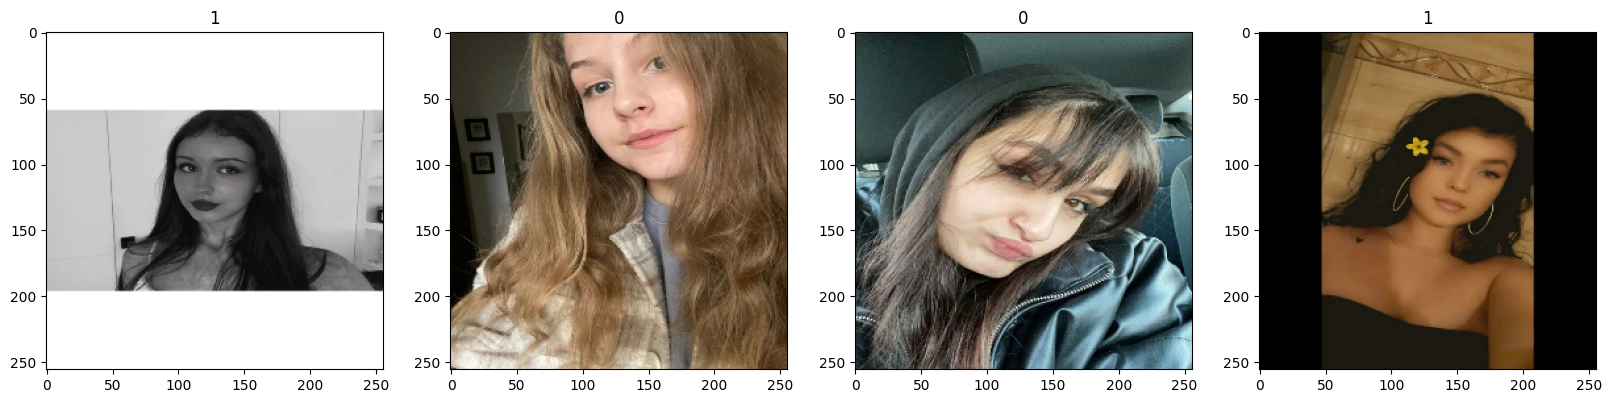

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
s = data.as_numpy_iterator().next()

In [19]:
s[0].max()

1.0

# 5. Split Data

In [20]:
len(data)

33

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [22]:
val_size, train_size, test_size

(6, 23, 4)

In [23]:
train_size+val_size+test_size

33

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
23/23 [==============================] - 39s 1s/step - loss: 0.7694 - accuracy: 0.4918 - val_loss: 0.6916 - val_accuracy: 0.5260
Epoch 2/20
23/23 [==============================] - 29s 1s/step - loss: 0.6932 - accuracy: 0.5312 - val_loss: 0.6893 - val_accuracy: 0.5833
Epoch 3/20
23/23 [==============================] - 27s 1s/step - loss: 0.6894 - accuracy: 0.6101 - val_loss: 0.6806 - val_accuracy: 0.6510
Epoch 4/20
23/23 [==============================] - 25s 1s/step - loss: 0.6568 - accuracy: 0.6535 - val_loss: 0.6632 - val_accuracy: 0.6250
Epoch 5/20
23/23 [==============================] - 26s 1s/step - loss: 0.6003 - accuracy: 0.7160 - val_loss: 0.6288 - val_accuracy: 0.6823
Epoch 6/20
23/23 [==============================] - 26s 1s/step - loss: 0.5156 - accuracy: 0.7636 - val_loss: 0.6223 - val_accuracy: 0.6719
Epoch 7/20
23/23 [==============================] - 26s 1s/step - loss: 0.4304 - accuracy: 0.8193 - val_loss: 0.5584 - val_accuracy: 0.6979
Epoch 8/20
23/23 [==

# 8. Plot Performance

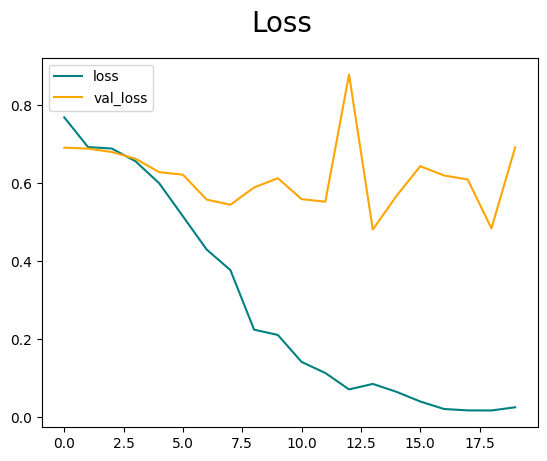

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

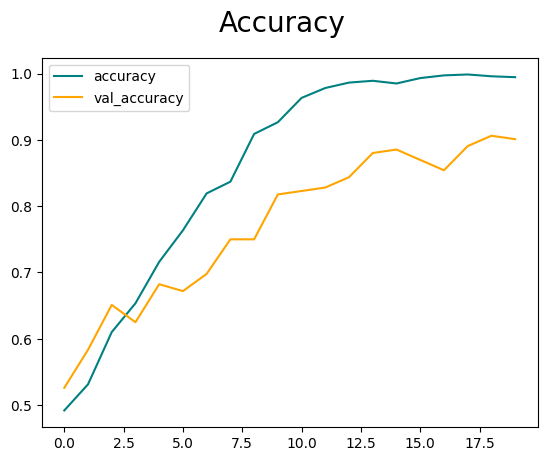

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 259ms/step


In [39]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.868852436542511, Recall: 0.9137930870056152, Accuracy: 0.8943089246749878


# 10. Test

In [40]:
import cv2

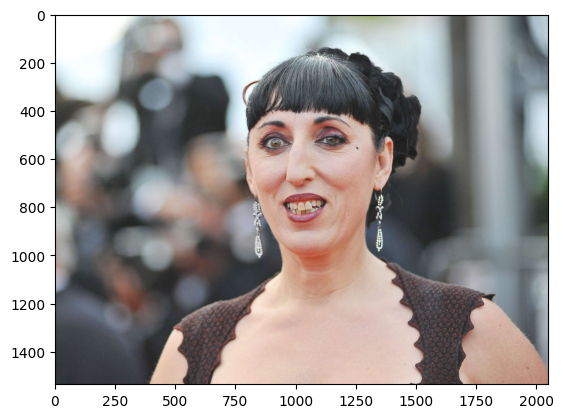

In [41]:
img = cv2.imread('like-dislike-test/testdislike5.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

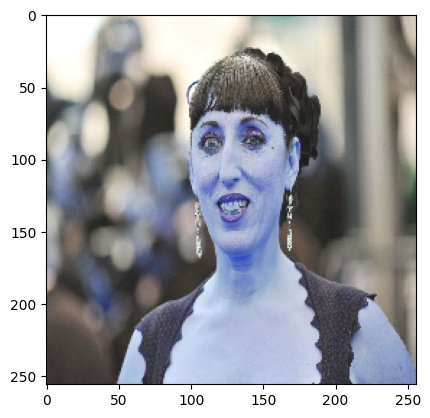

In [42]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 49ms/step


In [44]:
yhat

array([[0.9997078]], dtype=float32)

In [45]:
if yhat > 0.5: 
    print(f'Predicted class is Attractive')
else:
    print(f'Predicted class is Unattractive')

Predicted class is Attractive


# 11. Save the Model

In [46]:
from tensorflow.keras.models import load_model
import numpy as np

In [47]:
model.save(os.path.join('models','imageclassifier_1051hqphotos.h5'))

In [48]:
new_model = load_model('models/imageclassifier_1051hqphotos.h5')

In [49]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt

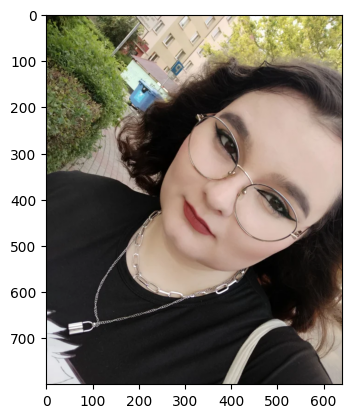

In [51]:
# img = cv2.imread('data/likes/hXS6GV2k2RzYJQCwNSQrre.jpg')
img = cv2.imread('like-dislike-test/testdislike10.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

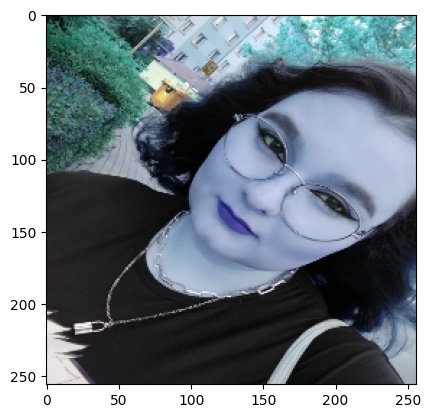

In [52]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [53]:
predict_class = new_model.predict(np.expand_dims(resize/255, 0))
if predict_class > 0.5: 
    print(f'{predict_class} Predicted class is Attractive')
else:
    print(f'{predict_class} Predicted class is Unattractive')

1/1 [==============================] - 0s 132ms/step
[[0.9998402]] Predicted class is Attractive


In [54]:
data_test_dir = 'like-dislike-test'
for image in os.listdir(data_test_dir): 
    image_path = os.path.join(data_test_dir, image)
    img = cv2.imread(image_path)
    resize_img = tf.image.resize(img, (256,256))
    predict_class = new_model.predict(np.expand_dims(resize_img/255, 0))
    print(image_path.split('\\')[-1])
    if predict_class > 0.5: 
        print(f'{predict_class} Predicted class is Attractive')
    else:
        print(f'{predict_class} Predicted class is Unattractive')

1/1 [==============================] - 0s 68ms/step
testdislike1.jpg
[[8.0293134e-08]] Predicted class is Unattractive
1/1 [==============================] - 0s 34ms/step
testdislike10.jpg
[[0.9998402]] Predicted class is Attractive
1/1 [==============================] - 0s 47ms/step
testdislike2.jpg
[[0.9588554]] Predicted class is Attractive
1/1 [==============================] - 0s 56ms/step
testdislike3.jpg
[[0.9997753]] Predicted class is Attractive
1/1 [==============================] - 0s 39ms/step
testdislike4.jpg
[[0.99999666]] Predicted class is Attractive
1/1 [==============================] - 0s 38ms/step
testdislike5.jpg
[[0.9997078]] Predicted class is Attractive
1/1 [==============================] - 0s 29ms/step
testdislike6.jpg
[[3.0989293e-07]] Predicted class is Unattractive
1/1 [==============================] - 0s 48ms/step
testdislike7.jpg
[[0.0096465]] Predicted class is Unattractive
1/1 [==============================] - 0s 57ms/step
testdislike8.jpg
[[0.9653533